In [29]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from typing import Tuple, Optional
import math
from torch import Tensor
from einops import rearrange
from diffusers import DDPMScheduler

Using device: cuda


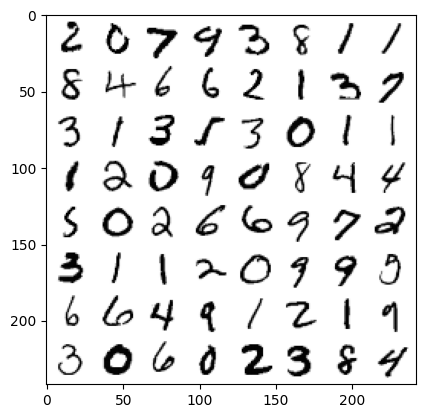

In [30]:
BATCH_SIZE = 64
NUM_EPOCHS = 3
LR = 1e-3 # Learning rate
T = 1000 # Timesteps
IMG_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

x, y = next(iter(train_dataloader))
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

In [31]:
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount

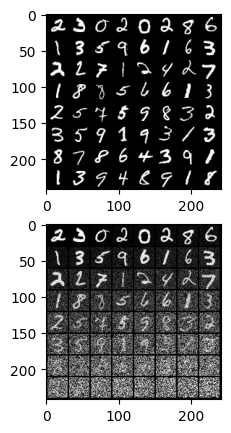

In [32]:
x, y = next(iter(train_dataloader))

# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='gray')

# Adding noise
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='gray');

In [33]:
class LinearNoiseScheduler(nn.Module):
    def __init__(self, timesteps: int = 1000, beta_start: float = 1e-4, beta_end: float = 0.02):
        super().__init__()
        self.timesteps = timesteps

        # Linearly spaced betas
        betas = torch.linspace(beta_start, beta_end, timesteps)

        # Precompute alphas and their cumulative products
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        # Register buffers (they move with the model to device, are saved with state_dict)
        self.register_buffer("betas", betas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)

    def add_noise(self, x: torch.Tensor, noise: torch.Tensor, t: torch.Tensor):
        """
        Add noise to input `x` at timestep `t`.

        Args:
            x: Tensor of shape (B, C, H, W)
            t: Tensor of shape (B,) with integer timesteps (0 <= t < T)

        Returns:
            noisy_x: noised version of `x`
            noise: the noise added
        """
        B, C, H, W = x.shape

        # Get alpha_cumprod_t for each sample in the batch
        alpha_cumprod_t = self.alphas_cumprod[t].view(B, 1, 1, 1)  # Shape (B, 1, 1, 1)

        # Apply noise: x_t = sqrt(a_t) * x + sqrt(1 - a_t) * noise
        noisy_x = torch.sqrt(alpha_cumprod_t) * x + torch.sqrt(1 - alpha_cumprod_t) * noise

        return noisy_x

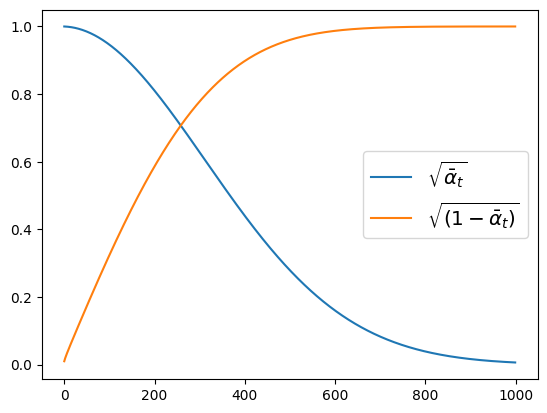

In [34]:
noise_scheduler = LinearNoiseScheduler(1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

In [35]:
class CosineNoiseScheduler(nn.Module):
    """
    s = 0.008 is set by the authors of the paper (section 3.2)
    """
    def __init__(self, timesteps = 1000, s=0.008):
        self.timesteps = timesteps
        self.s = s
        self.betas = self._cosine_beta_schedule()
        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def _cosine_beta_schedule(self):
        steps = self.timesteps + 1
        t = torch.linspace(0, self.timesteps, steps) / self.timesteps
        alphas_bar = torch.cos(((t + self.s) / (1 + self.s)) * math.pi * 0.5) ** 2 # Formula 2
        alphas_bar = alphas_bar / alphas_bar[0] # formula 1
        betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
        return torch.clamp(betas, max=0.999)

    def add_noise(self, x: torch.Tensor, noise: torch.Tensor ,t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Adds "t" noise to "x0"

        x:      [B, C, H, W]
        noise:  [B, C, H, W]
        t:      [B, ]
        
        Returns:
            x_t: the noisy image at timestep t
            noise: the noise that was added
        """
        alpha_bar = self.alpha_cumprod[t.long()].view(-1, 1, 1, 1)
        return torch.sqrt(alpha_bar) * x + torch.sqrt(1 - alpha_bar) * noise

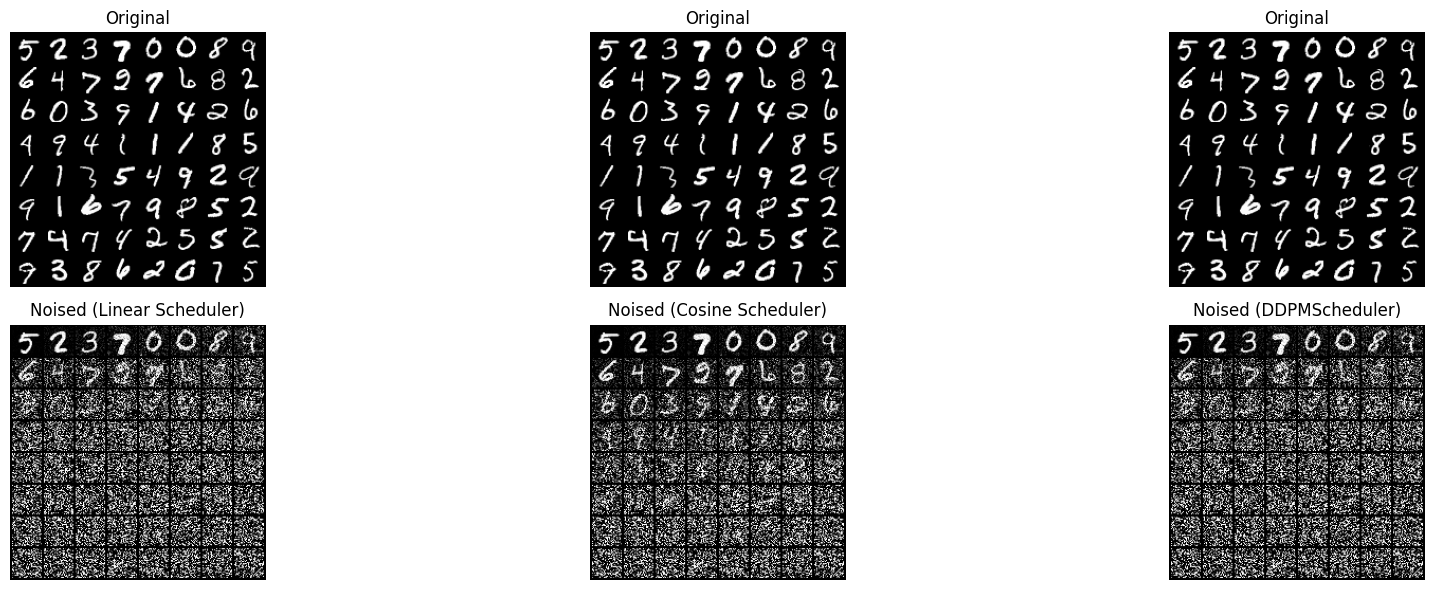

In [36]:
# Sample batch
x, y = next(iter(train_dataloader))  # Shape: (B, C, H, W)
x = x[:64]  # Use first 64 images for consistent layout

# Timesteps: left to right → increasing noise
T = 1000
t = torch.linspace(1, T - 1, 64).long()

# Generate one fixed noise tensor for fairness
noise = torch.randn_like(x)

# Linear scheduler
linear_sched = LinearNoiseScheduler(T)
noised_linear = linear_sched.add_noise(x, noise, t)

# Cosine scheduler
cosine_sched = CosineNoiseScheduler(T)
noised_cosine = cosine_sched.add_noise(x, noise, t)

# DDPMScheduler from diffusers
ddpm_sched = DDPMScheduler(num_train_timesteps=T, beta_schedule="linear")
alphas_cumprod = ddpm_sched.alphas_cumprod.to(x.device)
sqrt_alpha_bar = torch.sqrt(alphas_cumprod[t]).view(-1, 1, 1, 1)
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alphas_cumprod[t]).view(-1, 1, 1, 1)
noised_ddpm = sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise

# Plot side-by-side
fig, axs = plt.subplots(2, 3, figsize=(20, 6))

# Row 1: Clean input (duplicated)
for i, title in enumerate(["Original", "Original", "Original"]):
    axs[0, i].imshow(torchvision.utils.make_grid(x, nrow=8).permute(1, 2, 0).cpu().numpy())
    axs[0, i].set_title(title)
    axs[0, i].axis("off")

# Row 2: Noised inputs
axs[1, 0].imshow(torchvision.utils.make_grid(noised_linear.clip(0, 1), nrow=8).permute(1, 2, 0).cpu().numpy())
axs[1, 0].set_title("Noised (Linear Scheduler)")

axs[1, 1].imshow(torchvision.utils.make_grid(noised_cosine.clip(0, 1), nrow=8).permute(1, 2, 0).cpu().numpy())
axs[1, 1].set_title("Noised (Cosine Scheduler)")

axs[1, 2].imshow(torchvision.utils.make_grid(noised_ddpm.clip(0, 1), nrow=8).permute(1, 2, 0).cpu().numpy())
axs[1, 2].set_title("Noised (DDPMScheduler)")

# Remove axis ticks
for ax in axs[1]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# Model

In [37]:
class SinusoidalEmbedding(torch.nn.Module):
    def __init__(self, embedding_dim: int):
        super().__init__()
        self.embedding_dim = embedding_dim
        assert self.embedding_dim % 2 == 0, "embedding_dim must be even"
    
    def to(self, device):
        super().to(device)
        self.device = device
        return self

    def forward(self, timesteps: Tensor) -> Tensor:
        # Create the frequency spectrum
        half_dim = self.embedding_dim // 2
        exponent = -math.log(10000.0) / (half_dim - 1)
        freq = torch.exp(torch.arange(half_dim, dtype=torch.float32) * exponent)
        # freq = freq.to(self.device)

        # Expand timesteps for broadcasting
        timesteps = timesteps.float().unsqueeze(1)  # (N, 1)
        args = timesteps * freq.unsqueeze(0)        # (N, half_dim)

        # Concatenate sin and cos
        embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=1)  # (N, embedding_dim)

        return embedding

In [38]:
"""
From the paper:
"It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) [i.e. DoubleConvolution module] and a 2x2 max pooling operation with stride 2 for downsampling [i.e. DownSampling module]."
"""
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv_block(x)

class DownSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConvolution(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        down = self.conv(x)
        pool = self.pool(down)

        return down, pool

"""
From the paper: 
"Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU"
"""
class UpSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConvolution(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat((x1, x2), dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.dconv1 = DownSampling(in_channels, 32)
        self.dconv2 = DownSampling(32, 64)
        self.dconv3 = DownSampling(64, 128)
        self.dconv4 = DownSampling(128, 256)

        self.bottle_neck = DoubleConvolution(256, 512)

        self.uconv1 = UpSampling(512, 256)
        self.uconv2 = UpSampling(256, 128)
        self.uconv3 = UpSampling(128, 64)
        self.uconv4 = UpSampling(64, 32)

        self.out = nn.Conv2d(32, num_classes, kernel_size=1)
    
    def to(self, device):
        super().to(device)
        self.device = device
        return self

    def forward(self, x: Tensor, t: Optional[torch.Tensor]) -> torch.Tensor:
        """
        Parameters:
            x: [B, C, H, W]: Must be divisible by 2^4 (number of downsampling/upsampling blocks)
        """
        assert x.ndim == 4
        assert x.shape[2] % (2 ** 4) == 0, "x must be divisible by 2^4"
        assert x.shape[3] % (2 ** 4) == 0, "x must be divisible by 2^4"

        d1,p1 = self.dconv1(x)
        d2,p2 = self.dconv2(p1)
        d3,p3 = self.dconv3(p2)
        d4,p4 = self.dconv4(p3)

        b = self.bottle_neck(p4)

        u1 = self.uconv1(b, d4)
        u2 = self.uconv2(u1, d3)
        u3 = self.uconv3(u2, d2)
        u4 = self.uconv4(u3, d1)

        out = self.out(u4)
        return out

In [39]:
class Model(nn.Module):
    def __init__(self, noise_scheduler: str = "linear", input_channels: int = 1, num_classes: int = 1):
        super().__init__()

        # Noise scheduler selection
        if noise_scheduler == "linear":
            self.noise_scheduler = LinearNoiseScheduler()
        elif noise_scheduler == "cosine":
            self.noise_scheduler = CosineNoiseScheduler()
        else:
            raise ValueError(f"Unknown noise scheduler: {noise_scheduler}")
        
        # U-Net selection
        self.unet = UNet(in_channels=input_channels, num_classes=num_classes)

        # Time embeddings
        self.time_embedding_dim = 256
        self.sinusoidalEmbedding = SinusoidalEmbedding(self.time_embedding_dim) # TODO: Do something with time embeddings


    def to(self, device):
        super().to(device)
        self.noise_scheduler.to(device)
        self.unet.to(device)
        self.sinusoidalEmbedding.to(device)
        return self

    # def forward(self, x: Tensor, t: Tensor):
    #     """
    #     Forward diffusion (adding noise). Uses the selected noise scheduler.

    #     x: (B, C, H, W)
    #     t: (B, )
    #     """
    #     noise = torch.randn_like(x)
    #     return self.noise_scheduler.add_noise(x, noise, t)


    # Don't collect gradient information (no need to calculate loss here)
    # This is inference / sampling / generation, not training
    @torch.no_grad()
    def backward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Predicts the noise in the image and denoises it. Basically, a single reverse diffusion step. Use this with for loop to completly denoise the image and "generate" (adds details) a new one.

        Parameters:
            x: [B, C, H, W]
            t: [1, ]: The current diffusion step.
        """
        assert t.ndim == 1, "Timesteps must be a single value, not batch."
        assert x.ndim == 3 or (x.ndim == 4 and x.shape[0] == 1), "Backwards only works for a single image, not batch of images."

        betas_t = self.noise_scheduler.betas[t]
        sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1. - self.noise_scheduler.alpha_hat)[t]
        sqrt_recip_alphas_t = torch.sqrt(1.0 / self.noise_scheduler.alphas)[t]

        # Run the forward diffusion, ignore the noise output, we care about the noise prediction (epsilon_theta)
        epsilon_theta, noise = self.forward(x, t)

        # Broadcast to allow tensor operations (multiply, division) on batch of images (x)
        betas_t = rearrange(betas_t, 'b -> b 1 1 1')
        sqrt_one_minus_alphas_cumprod_t = rearrange(sqrt_one_minus_alphas_cumprod_t, "b -> b 1 1 1")
        sqrt_recip_alphas_t = rearrange(sqrt_recip_alphas_t, "b -> b 1 1 1")

        mean = sqrt_recip_alphas_t * (x - betas_t * epsilon_theta / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance
    
    @torch.no_grad()
    def sample(self) -> torch.Tensor:
        """
        Generate a single image randomly.
        """
        self.eval()
        self.unet.eval()

        img = torch.randn((1, 1, IMG_SIZE, IMG_SIZE)).to(device)
        for i in reversed(range(T)):
            t = torch.full((1,), i, dtype=torch.long, device=device)
            img = self.backward(img, t)
        return img

# Train

In [40]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
    return x*(1-amount) + noise*amount 

Number of trainable parameters in the model: 7,759,521
Finished epoch 0. Average loss for this epoch: 0.023119
Finished epoch 1. Average loss for this epoch: 0.011967
Finished epoch 2. Average loss for this epoch: 0.010578


(0.0, 0.1)

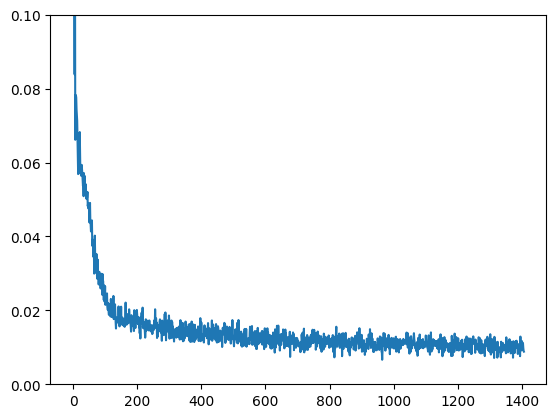

In [ ]:
model = Model()
model.to(device)

num_of_params = sum([p.numel() for p in model.parameters()])

print("Number of trainable parameters in the model: " + str(f"{num_of_params:,}"))

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU

        x = F.pad(x, (2, 2, 2, 2))

        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = model.unet.forward(noisy_x, None)

        # Calculate the loss
        loss = loss_fn(pred, x) # We try to predict the clean image X from noisy images. This is x_0 prediction, not epsilon-prediction.

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

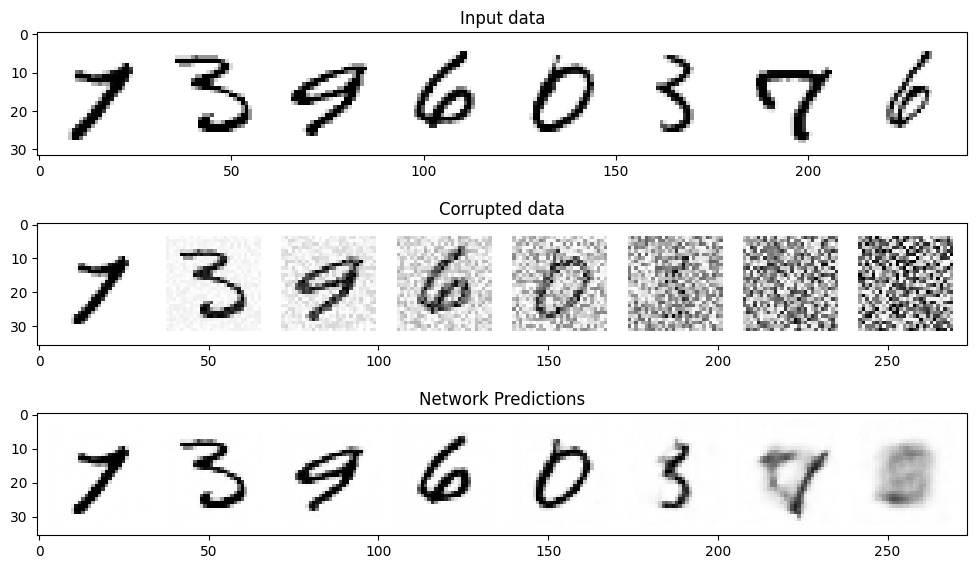

In [ ]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    noised_x = F.pad(noised_x.to(device), (2, 2, 2, 2))
    preds = model.unet(noised_x, None).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x.cpu())[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys')